# Explore logistic regression classification of 5,8 digits   
2017-11-27 Jeff Fessler, University of Michigan <br>
2018-11-27 Steven Whitaker - Convert to Julia v1.0 <br>
2019-11-25 Caroline Crockett - Add comments and sections, function template for NGD <br>
2020-11-19 Caroline Crockett - Fix NGD template and change order of the parts <br>
2021-11-23 Zongyu Li - Add `MLDatasets` and switch to Julia v1.6

### Group Formation and General Instructions
You may work individually, but we recommend that you work in pairs or groups of three. Find someone to work with and introduce yourself to them! One of you should copy the Google Document template and share the document with edit permissions with your group member(s): 
https://docs.google.com/document/d/1jw2209GnhUDYXsnoKfolb-HPoznJleDtFedsk-jb_hA/template/preview (you must use your umich email address to access this google document). 


The Google Document will include your answers to a couple of questions that will be asked. For each question, pick someone to type up your **group's** response. After completing the response, the group member should sign their name by typing it below the answer. For the next question, have a different group member respond and sign their name in the same way. Keep rotating until all the questions have been answered.

The goal of this group exercise is to formulate your response as a group to the problem. When finished, **one** student in the group must submit a PDF of the google document to gradescope, entering the uniquenames of **all** students in the group. One group submits exactly one PDF, but we expect the PDF from different groups to differ. The deadline for submitting to gradescope will be announced on Canvas. Only submit the filled-in google document; do not submit a download of this Jupyter notebook. 

### Overview
This task sheet develops logisitic regression based classification for classifying handwritten digits and then compares all the classification methods we have looked at this semester: nearest-angle-based classification (task 1), least-squares based classification (task 2), subspace-based classification (task 3 and 5), and logistic regression classification. 

We focus on classifying digits “5” and “8” because those are more difficult to distinguish and benefit from more advanced classification methods.

In [1]:
using LinearAlgebra
using Plots: plot, plot!, scatter, scatter!, savefig, title!, histogram, histogram!
using MIRTjim: jim
using MLDatasets 

### Part 0: Download and shape data
- x0, train0, and test0 contain data for digit "5"
- x1, train1, and test1 contain data for digit "8"

In [2]:
# read the MNIST data file for digits 5 and 8
# download from web if needed

if !@isdefined(data)
    digitn = [5, 8]
    tmpx, tmpy = MNIST.traindata(Float32)
    data = n -> tmpx[:,:,findall(tmpy .== n)[1:1000]] # 1st 1000 of digit n
    data = 255 * cat(dims=4, data.(digitn)...)
    nx, ny, nrep, ndigit = size(data)
    data = data[:,2:ny,:,:] # make images non-square to force debug
    ny = size(data,2)
    @show size(data)
end

x0 = data[:,:,:,1]
x1 = data[:,:,:,2]

@show size(x0);
@show size(x1);

size(data) = (28, 27, 1000, 2)
size(x0) = (28, 27, 1000)
size(x1) = (28, 27, 1000)


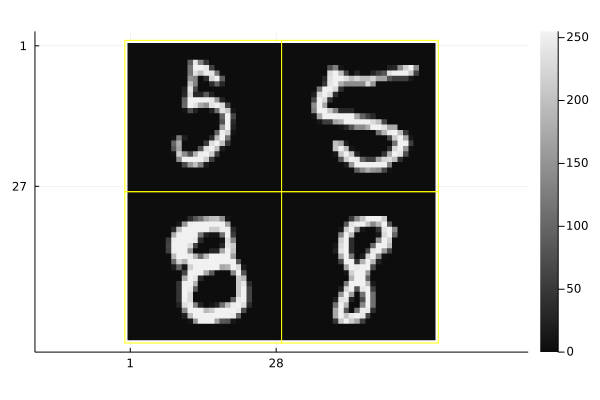

In [3]:
# look at a couple of the images
jim(cat(x0[:,:,44:45], x1[:,:,654:655], dims = 3))

In [4]:
# use some data for training, and some for test
ntrain = 100
ntest = nrep - ntrain
train0 = x0[:,:,1:ntrain] # training data
train1 = x1[:,:,1:ntrain]
test0 = x0[:,:,(ntrain+1):end] # testing data
test1 = x1[:,:,(ntrain+1):end];

In [11]:
size(train0)

(28, 27, 100)

In [13]:
train0
a = reshape(train0, 100, 28*27) * -1

100×756 Matrix{Float32}:
 -0.0   -0.0    -0.0  -0.0    -0.0  …    -0.0  -0.0    -0.0    -0.0  -0.0
 -0.0   -0.0    -0.0  -0.0    -0.0       -0.0  -0.0  -128.0    -0.0  -0.0
 -0.0   -0.0    -0.0  -0.0    -0.0       -0.0  -0.0  -255.0    -0.0  -0.0
 -0.0   -0.0   -18.0  -0.0    -0.0       -0.0  -0.0  -255.0    -0.0  -0.0
 -0.0   -0.0  -219.0  -0.0    -0.0       -0.0  -0.0  -128.0    -0.0  -0.0
 -0.0   -0.0  -253.0  -0.0    -0.0  …    -0.0  -0.0    -0.0    -0.0  -0.0
 -0.0   -0.0  -253.0  -0.0   -45.0       -0.0  -0.0    -0.0    -0.0  -0.0
 -0.0   -0.0  -253.0  -0.0  -186.0     -255.0  -0.0    -0.0    -0.0  -0.0
 -0.0   -0.0  -253.0  -0.0  -253.0     -255.0  -0.0    -0.0    -0.0  -0.0
 -0.0   -0.0  -253.0  -0.0  -253.0       -0.0  -0.0    -0.0    -0.0  -0.0
 -0.0   -0.0  -198.0  -0.0  -150.0  …    -0.0  -0.0  -128.0  -255.0  -0.0
 -0.0   -0.0  -182.0  -0.0   -27.0       -0.0  -0.0  -255.0  -255.0  -0.0
 -0.0   -0.0  -247.0  -0.0    -0.0       -0.0  -0.0  -128.0  -191.0  -0.0
  ⋮          

In [12]:
size(a)

(100, 756)

## Part 1
This part is the core part of the logistic regression classifier.
+ Following the course notes, form a training data matrix A that has 200 rows (one row per training data sample), where the rows
are multiplied by ±1 based on using a class label of -1 for digit 5 and class label +1 for digit 8 
+ Normalize each row of A to have unit norm.
+ Use the formula in the lecture notes to compute the Lipschitz constant for the logistic regression cost
function gradient for β = 0.1. Record the value of L in your report.
+ Implement Nesterov’s fast gradient descent (FGD).
+ Apply FGD to the logistic regression cost function. In your report, include the plot of the
cost function versus iteration and discuss whether FGD has converged. 

The logistic regression cost function is: <br>
$f(x) = \sum_i h(y_i ⟨x,v_i⟩) + \frac{β}{2} \lVert x \rVert_2^2$ <br>
$f(x) = 1_M' h.(Ax)         + \frac{β}{2} \lVert x \rVert_2^2 $

Where $h(z) = log(1+e^{-z})$ and $A[i,:] = y_i v_i'$

In [14]:
a = reshape(train0, 100, 28*27) * -1
b = reshape(train1, 100, 28*27) * 1

100×756 Matrix{Float32}:
 0.0    0.0    0.0  0.0    0.0    0.0  …    0.0  0.0    0.0    0.0  254.0
 0.0    0.0    0.0  0.0    0.0    0.0       0.0  0.0   43.0    0.0  254.0
 0.0    0.0    0.0  0.0    3.0    0.0       0.0  0.0  246.0    0.0  254.0
 0.0    0.0    0.0  0.0  171.0    0.0       0.0  0.0  254.0    0.0  136.0
 0.0    0.0    0.0  0.0  254.0    0.0       0.0  0.0  159.0    0.0   82.0
 0.0    0.0    0.0  0.0  254.0    0.0  …  242.0  0.0    6.0    0.0   15.0
 0.0    0.0    0.0  0.0  254.0    0.0     254.0  0.0    0.0    0.0    0.0
 0.0    0.0  110.0  0.0  179.0    0.0     215.0  0.0    0.0    0.0    0.0
 0.0    0.0  253.0  0.0    0.0    0.0      36.0  0.0  202.0    0.0    0.0
 0.0    0.0  253.0  0.0    0.0    0.0       0.0  0.0  254.0    0.0    0.0
 0.0    0.0  253.0  0.0    0.0    0.0  …    0.0  0.0   52.0    0.0    0.0
 0.0    0.0  246.0  0.0    0.0   64.0       0.0  0.0    0.0    0.0    0.0
 0.0    0.0  161.0  0.0    0.0  239.0       0.0  0.0    0.0  179.0    0.0
 ⋮           

In [16]:
# TODO

# form the A matrix using product of each feature v_i with y_i = ±1
A = vcat(a, b)
β = 0.1; # choose regularization parameter manually for now

In [17]:
A

200×756 Matrix{Float32}:
 -0.0   -0.0    -0.0  -0.0    -0.0  …    -0.0  -0.0    -0.0    -0.0  -0.0
 -0.0   -0.0    -0.0  -0.0    -0.0       -0.0  -0.0  -128.0    -0.0  -0.0
 -0.0   -0.0    -0.0  -0.0    -0.0       -0.0  -0.0  -255.0    -0.0  -0.0
 -0.0   -0.0   -18.0  -0.0    -0.0       -0.0  -0.0  -255.0    -0.0  -0.0
 -0.0   -0.0  -219.0  -0.0    -0.0       -0.0  -0.0  -128.0    -0.0  -0.0
 -0.0   -0.0  -253.0  -0.0    -0.0  …    -0.0  -0.0    -0.0    -0.0  -0.0
 -0.0   -0.0  -253.0  -0.0   -45.0       -0.0  -0.0    -0.0    -0.0  -0.0
 -0.0   -0.0  -253.0  -0.0  -186.0     -255.0  -0.0    -0.0    -0.0  -0.0
 -0.0   -0.0  -253.0  -0.0  -253.0     -255.0  -0.0    -0.0    -0.0  -0.0
 -0.0   -0.0  -253.0  -0.0  -253.0       -0.0  -0.0    -0.0    -0.0  -0.0
 -0.0   -0.0  -198.0  -0.0  -150.0  …    -0.0  -0.0  -128.0  -255.0  -0.0
 -0.0   -0.0  -182.0  -0.0   -27.0       -0.0  -0.0  -255.0  -255.0  -0.0
 -0.0   -0.0  -247.0  -0.0    -0.0       -0.0  -0.0  -128.0  -191.0  -0.0
  ⋮          

In [ ]:
# TODO  
# set up for logistic regression: pot and dpot are both scalar functions 
pot = (z) -> # logistic loss function (aka potential function)
dpot = (z) -> # derivative of the potential function 

# cost is the f(x) function given above
# both cost and grad are functions that take a vector as an input 
cost = (x) -> # overall cost function
grad = (x) -> # gradient of logistic regression cost function 
L = # Lipshitz constant

@show round(L, digits=2);

We will use Nesterov's FGD (fast gradient descent) to learn the weights. 
See homework 6, problem 8 for help completing the function. 
The momentum step is the same as in that homework problem; 
the difference is that you must use the input argument `grad` to calculate the gradient 
instead of hard-coding the least squares gradient. 
You will then call `ngd` with the `grad` function above for the logistic regression gradient.

In [ ]:
# TODO  

""" 
``x, out = ngd(grad, x0; nIters::Int = 200, L::Real = 0, fun = (x, iter) -> 0)

Implementation of Nesterov's FGD (fast gradient descent),
given the gradient of the cost function

In: 
- grad is a function that takes in x and calculates the gradient of the cost function with respect to x
- x0 is an initial point
Optional: 
- nIters is the number of iterations
- L is the Lipschitz constant of the derivative of the cost function 
- fun is a function to evaluate every iteration 

Out: (x, out) 
- x is the guess of the minimizer after running nIters iterations 
- out is an Array of evaluations of the fun function 
""" 
function ngd(grad, x0; niter::Int = 200, L::Real = 0, fun = (x, iter) -> 0)
    # these lines initialize the output array to have the correct size/type 
    fun_x0 = fun(x0, 0)
    out = similar(Array{typeof(fun_x0)}, niter+1)
    out[1] = fun_x0
    
    # set up some variables 
    
    # run the FGD for niter iterations
    for iter=1:niter
        # you need to update t, x, and z here 
        out[iter+1] = fun(x, iter) # compute user-defined function (typically cost function) each iteration
    end
    
    return x, out 
end

In [ ]:
# Include this just for comparison 
function gd(grad, x0; niter::Int = 200, L::Real = 0, fun = (x, iter) -> 0)
    # these lines initialize the output array to have the correct size/type 
    fun_x0 = fun(x0, 0)
    out = similar(Array{typeof(fun_x0)}, niter+1)
    out[1] = fun_x0
    
    # run GD for niter iterations
    x = x0
    for iter=1:niter
        x = x - grad(x) / L
        out[iter+1] = fun(x, iter) # compute cost each iteration
    end
    
    return x, out 
end

Before submitting your NGD code to the autograder, test it using the two blocks below. If your code is working, the cost function should descend to 39.33
Include the plot of the cost function in your report and comment about whether or not FGD has converged.

In [ ]:
# use the previously set up gradient and cost function to call the lsngd function 
x0 = zeros(nx*ny)
niter = 100
x_fgd, cost_fgd = ngd(grad, x0, niter = niter, L=L, fun = (x, iter) -> cost(x));

@show round(cost_fgd[end], digits=2);

In [ ]:
scatter(1:niter, cost_fgd, xlabel="Iteration", ylabel="Cost", label="FGD")

In [ ]:
# For comparison, also plot the cost function for standard (not fast) GD
_, cost_gd = gd(grad, x0, niter = niter, L=L, fun = (x, iter) -> cost(x));
scatter(1:niter, cost_gd, xlabel="Iteration", ylabel="Cost", label="GD")
scatter!(1:niter, cost_fgd, xlabel="Iteration", ylabel="Cost", label="FGD")

In [ ]:
#savefig("task6_part1.png")

## Part 2: Test the LR classifier 
+ The above test code ran 100 iterations of FGD. Now, display the final iterate xk for k = 100 by reshaping it into a 2D image.
Include a picture of the weights in your report. Think about features of the weights and if they make sense (you do not need to include this in your report).  
+ Use the logistic regression weights to classify the test data. 
Report the classification accuracy in your document.
+ Make histograms of the inner products $<\hat{x}, v_m>$ for the test data using the $\hat{x}$ from the  logistic regression method, to see how well separated the two distributions
(for 5 and for 8) are. Include the histograms in your report.

In [ ]:
# examine classifier weights
jim(reshape(x_fgd, nx, ny))
title!("Logistic regression weights")
#savefig("task6_part2_weights.png")

In [ ]:
# logistic regression based classification
log_correct0 = sum(sign.(reshape(test0, nx*ny, :)' * x_fgd) .== 1)
@show round(log_correct0 / ntest, digits=4)
log_correct1 = sum(sign.(reshape(test1, nx*ny, :)' * x_fgd) .== -1)
@show round(log_correct1 / ntest, digits=4);

In [ ]:
# histogram of inner products - logistic
histogram(reshape(test0, nx*ny, :)' * x_fgd, title = "Logistic", xlabel = "Inner Product", label = "5", alpha = 0.7, nbins = 30)
histogram!(reshape(test1, nx*ny, :)' * x_fgd, label = "8", alpha = 0.7, nbins = 30)
#savefig("task6_part2_histLR.png")

## Part 3: Subspace based classification
This next part of the notebook is the subspace based classification method that you've previously coded. Now we apply that method to the digits 5 and 8. To make sure your data is properly set-up, first run all the cells under Task 1 and report the classification accuracies in your document when using three basis vectors for both classes. If everything is working properly, both accuracies should be between 86% and 92%. Include these accuracies in your report. 

Note, you do not have to modify any code since this task is replicating code from a previous assignment, but now applying it to the digits 5 and 8.

Next, use the scree plot to pick the number of basis vectors to use for your classifier and also report this classification accuracy in your report. There are many possible reasonable values - we are looking for you to describe how you pick one. 

In [ ]:
# Use training data to estimate the subspaces
u0, s0, _ = svd(reshape(train0, nx*ny, :))
u1, s1, _ = svd(reshape(train1, nx*ny, :))

r0, r1 = 3, 3 # start with three basis vectors 
q0 = reshape(u0[:,1:r0], nx, ny, :)
q1 = reshape(u1[:,1:r1], nx, ny, :);

In [ ]:
# show images of the 1st 3 components of first digit subspace
# you do not need to include this image in your report 
jim(cat(q0[:,:,1:3],q1[:,:,1:3],dims=3))

In [ ]:
## Classify all the test data based on your subspace estimates
# and count number of misclassified digits
Q0 = reshape(q0, nx*ny, r0)
Q1 = reshape(q1, nx*ny, r1)

y0 = reshape(test0, nx*ny, :)
y00 = y0 - Q0*(Q0'*y0)
y01 = y0 - Q1*(Q1'*y0)
correct0 = (mapslices(norm, y00, dims = 1) .< mapslices(norm, y01, dims = 1))[:]
@show round(sum(correct0) / ntest, digits=4)

y1 = reshape(test1, nx*ny, :)
y10 = y1 - Q0*(Q0'*y1)
y11 = y1 - Q1*(Q1'*y1)
correct1 = (mapslices(norm, y10, dims = 1) .> mapslices(norm, y11, dims = 1))[:]
@show round(sum(correct1) / ntest, digits=4);

In [ ]:
# show some bad cases 
bad1 = findall(correct1 .== false)
bad0 = findall(correct0 .== false)
jim(cat(test1[:,:,bad1[1:2]], test0[:,:,bad0[1:2]], dims=3))

In [ ]:
# Examine the scree plots to choose a rank!
plot(1:ntrain, s0, line=(:dots, :blue), label="digit 5")
plot!(1:ntrain, s1, line=(:dots,:red), label="digit 8")

In [ ]:
# TODO: pick the number of basis to use for classification based on the scree plot

r0, r1 = ,  # TODO 
q0 = reshape(u0[:,1:r0], nx, ny, :)
q1 = reshape(u1[:,1:r1], nx, ny, :);

# re-run the classification test code to get the new test accuracies 
# report your choice of r0 and r1 along with the new accuracies in your report 

## Part 4: least-squares based classifier 
This part of the notebook is the least-squared based classification method that you've previously coded. Now we apply that method to the digits 5 and 8. Run all the cells under Part 4 and report the classification accuracies (for the test digits) in your document. If everything is working properly, both accuracies should be between 77% and 89%.

Note, you do not have to modify any code since this task is replicating code from a previous assignment, but now applying it to the digits 5 and 8.

In your report, comment on how the histogram for the LS classifier and the histogram for the logistic regression-based classifier relate to the classification accuracies for the two methods.

In [ ]:
# LS-based classifier
A = cat(reshape(train0, :, ntrain)',  -1 .*reshape(train1, :, ntrain)', dims = 1)
b = [ones(ntrain); ones(ntrain)] 
x_ls = A \ b
jim(reshape(x_ls, nx, ny)) # look at the LS regression coefficients

In [ ]:
# assess the classification accuracy based on the LS coefficients 'x_ls'
ls_correct0 = sum(sign.(reshape(test0, nx*ny, :)' * x_ls) .== 1)
@show round(ls_correct0 / ntest, digits=4)
ls_correct1 = sum(sign.(reshape(test1, nx*ny, :)' * x_ls) .== -1)
@show round(ls_correct1 / ntest, digits=4);

In [ ]:
# histogram of inner products - LS
histogram(reshape(test0, nx*ny, :)' * x_ls, title = "LS", xlabel = "Inner Product", label = "5", alpha = 0.7, nbins = 30)
histogram!(reshape(test1, nx*ny, :)' * x_ls, label = "8", alpha = 0.7, nbins = 30)
#savefig("task6_part4_histLS")

In [ ]:
# In your report, explain why this block of code gives 100% classification accuracy 
# hint: examine size() of various components
tmp0 = sum(sign.(reshape(train0, nx*ny, :)' * x_ls) .== 1)
@show tmp0 / ntrain
tmp1 = sum(sign.(reshape(train1, nx*ny, :)' * x_ls) .== -1)
@show tmp1 / ntrain;

Optional: try using Tikhonov regularization to see if you can improve the classification accuracy.


## Part 5: Nearest neighbor classification by angle
The last part of the notebook considers classification by nearest neighbor, using the angle between vectors as the measure of distance. Include the classification accuracy in your report. Also think about why we might not want to use this classifier in a real application, even if it performs well (you do not need to write this up for your report). 

In [ ]:
getangle = (v1, v2) -> acos(v1'*v2/(norm(v1)*norm(v2))) # this is equivalent 

"""
class = classify(test, train0, train1)

Binary classification based on the minumum angle between the test vector and each vector in the training data. 

In: 
- test     :    Vector of length M. M is the number of features. 
- train0   :    M x N0 matrix. N0 is the number of training samples of class 0.
- train1   :    M x N1 matrix. N1 is the number of training samples of class 1.  

Out:
- The class (0 or 1) for every vector in test. 
"""
function classify_angle(test, train0, train1)
    θ0min = minimum([getangle(test, train0[:,n]) for n=1:size(train0,2)])
    θ1min = minimum([getangle(test, train1[:,n]) for n=1:size(train1,2)])

    return θ0min < θ1min ? 0 : 1
end

In [ ]:
train0r = reshape(train0, :, ntrain) # reshape the data so that each column is a vector with the data form one image 
train1r = reshape(train1, :, ntrain)
test0r = reshape(test0, :, ntest)
test1r = reshape(test1, :, ntest)

correct0 = [classify_angle(test0r[:,n], train0r, train1r) == 0 for n = 1:ntest]
correct1 = [classify_angle(test1r[:,n], train0r, train1r) == 1 for n = 1:ntest]

@show round(sum(correct0) / ntest, digits=4)
@show round(sum(correct1) / ntest, digits=4);

## Optional extensions
+ Investigate different regularization parameters β for logistic regression. Do not use all of the test data for tuning that parameter,
otherwise you are essentially training with the test data! Instead, use, say, 100 samples for tuning β, and
then test with the remaining “untouched” 800 images.
+ Use this web tool to capture your own “hand-written” digit:
http://web.eecs.umich.edu/~fessler/course/551/r/digitdraw.htm and save it as a JPG file. (On
my Mac this worked on Chrome, try another browser if your first try fails.)
Read that image into Julia (or Matlab) and down-size it to be the appropriate size for your digit
classifier. Apply your classifier and see if it identifies the correct digit.
+ Extend the notebook to multi-class classification (up to all 10 digits)